In [3]:
import os
import sys
import pandas as pd
from PIL import Image
import imagehash
from tqdm.notebook import tqdm
import pickle
import shutil
import plotly.graph_objects as go
import plotly.subplots as sp
import base64
import math
DATA_DIR = os.path.expanduser('~/data/custom_korean_family_dataset_resolution_128')
sys.path.append('../src')

In [4]:
df_train = pd.read_csv(os.path.join(DATA_DIR, 'custom_train_dataset.csv'))
df_forget = df_train[:1500]
df_retain = df_train[1500:]

In [5]:
def copy_images(df, source_directory, destination_directory):
    os.makedirs(destination_directory, exist_ok=True)

    # Iterate through the DataFrame
    for image_path in df["image_path"]:
        # Construct full file paths
        source_path = os.path.join(source_directory, image_path)
        destination_path = os.path.join(
            destination_directory, os.path.basename(image_path)
        )

        # Copy the file
        try:
            shutil.copy(source_path, destination_path)
            print(f"Copied {image_path} to {destination_directory}")
        except FileNotFoundError:
            print(f"File {source_path} not found.")
        except Exception as e:
            print(f"Error copying {image_path}: {e}")

In [6]:
if not os.path.exists(os.path.join(DATA_DIR, 'forget_images')):
    os.makedirs(os.path.join(DATA_DIR, 'forget_images'))
    copy_images(df_forget, os.path.join(DATA_DIR, 'train_images'), os.path.join(DATA_DIR, 'forget_images'))
if not os.path.exists(os.path.join(DATA_DIR, 'retain_images')):
    os.makedirs(os.path.join(DATA_DIR, 'retain_images'))
    copy_images(df_retain, os.path.join(DATA_DIR, 'train_images'), os.path.join(DATA_DIR, 'retain_images'))

train_images_path = os.path.join(DATA_DIR, 'train_images')
val_images_path = os.path.join(DATA_DIR, 'val_images')
test_images_path = os.path.join(DATA_DIR, 'test_images')
forget_images_path = os.path.join(DATA_DIR, 'forget_images')
retain_images_path = os.path.join(DATA_DIR, 'retain_images')

In [7]:
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data


def compute_and_store_hashes(image_folder, hash_function=imagehash.phash, output_file='image_hashes.pkl'):
    image_hashes = {}

    for filename in tqdm(os.listdir(image_folder)):
        image_path = os.path.join(image_folder, filename)
        try:
            image = Image.open(image_path)
            hash_value = hash_function(image)
            image_hashes[filename] = hash_value
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    # Save the hashes to a file
    with open(output_file, 'wb') as f:
        pickle.dump(image_hashes, f)
    return image_hashes


In [8]:
train_hashes = (
    load_pickle("mufac_train_image_hashes.pkl")
    if os.path.exists("mufac_train_image_hashes.pkl")
    else compute_and_store_hashes(
        os.path.join(DATA_DIR, "train_images"),
        output_file="mufac_train_image_hashes.pkl",
    )
)
val_hashes = (
    load_pickle("mufac_val_image_hashes.pkl")
    if os.path.exists("mufac_val_image_hashes.pkl")
    else compute_and_store_hashes(
        os.path.join(DATA_DIR, "val_images"),
        output_file="mufac_val_image_hashes.pkl",
    )
)
test_hashes = (
    load_pickle("mufac_test_image_hashes.pkl")
    if os.path.exists("mufac_test_image_hashes.pkl")
    else compute_and_store_hashes(
        os.path.join(DATA_DIR, "test_images"),
        output_file="mufac_test_image_hashes.pkl",
    )
)
retain_hashes = (
    load_pickle("mufac_retain_image_hashes.pkl")
    if os.path.exists("mufac_retain_image_hashes.pkl")
    else compute_and_store_hashes(
        os.path.join(DATA_DIR, "retain_images"),
        output_file="mufac_retain_image_hashes.pkl",
    )
)
forget_hashes = (
    load_pickle("mufac_forget_image_hashes.pkl")
    if os.path.exists("mufac_forget_image_hashes.pkl")
    else compute_and_store_hashes(
        os.path.join(DATA_DIR, "forget_images"),
        output_file="mufac_forget_image_hashes.pkl",
    )
)

In [9]:
def find_leakage(image_hashesA, image_hashesB, pickle_filename):
    duplicates = []
    for filenameA, hash_valueA in tqdm(image_hashesA.items()):
        for filenameB, hash_valueB in image_hashesB.items():
            if hash_valueA == hash_valueB:
                duplicates.append((filenameA, filenameB))
    with open(pickle_filename, 'wb') as f:
        pickle.dump(duplicates, f)
    return duplicates


In [10]:
train_val_leakage = load_pickle('mufac_train_val_leakage.pkl') if os.path.exists('mufac_train_val_leakage.pkl') else find_leakage(train_hashes, val_hashes, "mufac_train_val_leakage.pkl")
train_test_leakage = load_pickle('mufac_train_test_leakage.pkl') if os.path.exists('mufac_train_test_leakage.pkl') else find_leakage(train_hashes, test_hashes, "mufac_train_test_leakage.pkl")
val_test_leakage = load_pickle('mufac_val_test_leakage.pkl') if os.path.exists('mufac_val_test_leakage.pkl') else find_leakage(val_hashes, test_hashes, "mufac_val_test_leakage.pkl")
forget_retain_leakage = load_pickle('mufac_forget_retain_leakage.pkl') if os.path.exists('mufac_forget_retain_leakage.pkl') else find_leakage(forget_hashes, retain_hashes, "mufac_forget_retain_leakage.pkl")

In [11]:
print(f"Found {len(train_val_leakage)} similar images on train_val sets")
print(f"Found {len(train_test_leakage)} similar images on train_test sets")
print(f"Found {len(val_test_leakage)} similar images on val_test sets")
print(f"Found {len(forget_retain_leakage)} similar images on forget_retain sets")

Found 0 similar images on train_val sets
Found 54 similar images on train_test sets
Found 16 similar images on val_test sets
Found 26 similar images on forget_retain sets


# Plot the leakage

In [12]:
def encode_image(image_path):
    """Encode an image to base64."""
    with open(image_path, 'rb') as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')


def create_image_plot(pairs, output_file="image_pairs.html", splits=("train", "test")):
    """Create an HTML file with image pairs displayed side by side."""

    # Define paths to image directories
    img1_dirpath = os.path.join(DATA_DIR, f"{splits[0]}_images")
    img2_dirpath = os.path.join(DATA_DIR, f"{splits[1]}_images")

    # Calculate grid dimensions
    cols = 2
    rows = len(pairs)

    # Adjust vertical spacing based on the number of rows
    max_vertical_spacing = 1 / (rows - 1) if rows > 1 else 0.015
    vertical_spacing = min(0.015, max_vertical_spacing)

    # Create subplots
    fig = sp.make_subplots(
        rows=rows,
        cols=cols,
        vertical_spacing=vertical_spacing,
        horizontal_spacing=0.00,
    )

    for i, (img1_path, img2_path) in enumerate(pairs):
        # Encode images to base64
        img1_encoded = encode_image(os.path.join(img1_dirpath, img1_path))
        img2_encoded = encode_image(os.path.join(img2_dirpath, img2_path))

        # Determine row and column for the subplot
        row = i // cols + 1

        # Add image traces
        fig.add_trace(
            go.Image(source=f"data:image/png;base64,{img1_encoded}"),
            row=row,
            col=1,
        )
        fig.add_trace(
            go.Image(source=f"data:image/png;base64,{img2_encoded}"),
            row=row,
            col=2,
        )

        # set a subplot title here
        fig.update_xaxes(title_text=f"{splits[0]}_images/{img1_path}", row=row, col=1, showticklabels=False)
        fig.update_xaxes(title_text=f"{splits[1]}_images/{img2_path}", row=row, col=2, showticklabels=False)
        fig.update_yaxes(row=row, col=1, showticklabels=False)
        fig.update_yaxes(row=row, col=2, showticklabels=False)


    # Update layout
    fig.update_layout(
        title_text=f"{splits[0]} - {splits[1]} duplicates",
        title_x=0.5,
        height=rows * 500,  # Adjust height based on number of rows
        width=1200,
        showlegend=False,
        xaxis=dict(showgrid=False, showticklabels=False),
        xaxis2=dict(showgrid=False, showticklabels=False),
        yaxis=dict(showgrid=False, showticklabels=False),
        yaxis2=dict(showgrid=False, showticklabels=False),
    )

    # Save the Plotly figure as an HTML file
    fig.write_html(output_file)

In [13]:
create_image_plot(train_test_leakage, output_file="mufac_train_test_leakage.html", splits=("train", "test"))
create_image_plot(val_test_leakage, output_file="mufac_val_test_leakage.html", splits=("val", "test"))
create_image_plot(forget_retain_leakage, output_file="mufac_forget_retain_leakage.html", splits=("forget", "retain"))

# Search for duplicates in the FORGET, RETAIN, TEST, VAL sets

In [14]:
def find_duplicates(image_hashes, pickle_filename):
    duplicates = []
    image_hashes_items = list(image_hashes.items())
    for i in tqdm(range(len(image_hashes_items))):
        for j in range(i + 1, len(image_hashes_items)):
            filenameA, hash_valueA = image_hashes_items[i]
            filenameB, hash_valueB = image_hashes_items[j]
            if hash_valueA == hash_valueB:
                duplicates.append((filenameA, filenameB))
    # with open(f"{pickle_filename}.pkl", "wb") as f:
    #     pickle.dump(duplicates, f)
    print(f"Found {len(duplicates)} duplicates in {pickle_filename}")
    return duplicates

In [15]:
forget_duplicates = (
    load_pickle("mufac_forget_duplicates.pkl")
    if os.path.exists("mufac_forget_duplicates.pkl")
    else find_duplicates(forget_hashes, "mufac_forget_duplicates")
)
retain_duplicates = (
    load_pickle("mufac_retain_duplicates.pkl")
    if os.path.exists("mufac_retain_duplicates.pkl")
    else find_duplicates(retain_hashes, "mufac_retain_duplicates")
)
val_duplicates = (
    load_pickle("mufac_val_duplicates.pkl")
    if os.path.exists("mufac_val_duplicates.pkl")
    else find_duplicates(val_hashes, "mufac_val_duplicates")
)
test_duplicates = (
    load_pickle("mufac_test_duplicates.pkl")
    if os.path.exists("mufac_test_duplicates.pkl")
    else find_duplicates(test_hashes, "mufac_test_duplicates")
)

In [16]:
print(f"Found {len(forget_duplicates)} duplicates in forget set")
print(f"Found {len(retain_duplicates)} duplicates in retain set")
print(f"Found {len(val_duplicates)} duplicates in val set")
print(f"Found {len(test_duplicates)} duplicates in test set")

Found 420 duplicates in forget set
Found 3012 duplicates in retain set
Found 312 duplicates in val set
Found 359 duplicates in test set


In [17]:
def clean_redundant_duplicates(duplicates, pickle_filename):
    duplicates = duplicates[::-1]
    unique_duplicates = []
    for i in range(len(duplicates)):
        imgA, imgB = duplicates[i]
        if imgB not in [x[1] for x in duplicates[i + 1:]]:
            unique_duplicates.append((imgA, imgB))
    with open(f"{pickle_filename}.pkl", "wb") as f:
        pickle.dump(unique_duplicates, f)
    print(f"Found {len(unique_duplicates)} unique duplicates in {pickle_filename}")
    return unique_duplicates

In [18]:
forget_duplicates = (
    load_pickle("mufac_forget_duplicates.pkl")
    if os.path.exists("mufac_forget_duplicates.pkl")
    else clean_redundant_duplicates(forget_duplicates, "mufac_forget_duplicates")
)
retain_duplicates = (
    load_pickle("mufac_retain_duplicates.pkl")
    if os.path.exists("mufac_retain_duplicates.pkl")
    else clean_redundant_duplicates(retain_duplicates, "mufac_retain_duplicates")
)
val_duplicates = (
    load_pickle("mufac_val_duplicates.pkl")
    if os.path.exists("mufac_val_duplicates.pkl")
    else clean_redundant_duplicates(val_duplicates, "mufac_val_duplicates")
)
test_duplicates = (
    load_pickle("mufac_test_duplicates.pkl")
    if os.path.exists("mufac_test_duplicates.pkl")
    else clean_redundant_duplicates(test_duplicates, "mufac_test_duplicates")
)

In [19]:
create_image_plot(
    forget_duplicates[:15],
    output_file="mufac_forget_duplicates.html",
    splits=("forget", "forget"),
)
create_image_plot(
    retain_duplicates[:15],
    output_file="mufac_retain_duplicates.html",
    splits=("retain", "retain"),
)
create_image_plot(
    val_duplicates[:15],
    output_file="mufac_val_duplicates.html",
    splits=("val", "val"),
)
create_image_plot(
    test_duplicates[:15],
    output_file="mufac_test_duplicates.html",
    splits=("test", "test"),
)

# Clean the TRAIN set from leaked images and duplicates

In [20]:
df_train = pd.read_csv(os.path.join(DATA_DIR, 'custom_train_dataset.csv'))
df_train_clean = pd.read_csv(os.path.join(f"{DATA_DIR}", 'custom_train_dataset.csv'))


df_val = pd.read_csv(os.path.join(DATA_DIR, 'custom_val_dataset.csv'))
df_val_clean = pd.read_csv(os.path.join(f"{DATA_DIR}", 'custom_val_dataset.csv'))

df_test = pd.read_csv(os.path.join(DATA_DIR, 'custom_test_dataset.csv'))
df_test_clean = pd.read_csv(os.path.join(f"{DATA_DIR}", 'custom_test_dataset.csv'))

In [21]:
indices_forget = []
indices_retain = []
for forget_image, retain_image in forget_retain_leakage:
    index_forget = df_train[df_train['image_path'] == forget_image].index[0]
    index_retain = df_train[df_train['image_path'] == retain_image].index[0]
    indices_forget.append(index_forget)
    indices_retain.append(index_retain)
unique_forget_indices = list(set(indices_forget))
unique_retain_indices = list(set(indices_retain))
print(f"Length of unique forget indices: {len(unique_forget_indices)}")
print(f"Length of unique retain indices: {len(unique_retain_indices)}")
print("There are duplicates in the retain set!!!")

Length of unique forget indices: 18
Length of unique retain indices: 26
There are duplicates in the retain set!!!


## Remove instances that cause leakage.

In [22]:
# Remove forget instances 
for forget_image, retain_image in forget_retain_leakage:
    df_train_clean.drop(df_train_clean[df_train_clean["image_path"] == forget_image].index, inplace=True)
print(f"len(df_train_clean): {len(df_train_clean)}")
print(f"len(df_train) - len(df_train_clean) =  {len(df_train) - len(df_train_clean)}")
print("Number of Forget instances Before and After: 1500 and 1482")

len(df_train_clean): 10007
len(df_train) - len(df_train_clean) =  18
Number of Forget instances Before and After: 1500 and 1482


In [23]:
# Remove val instances that appear in the test set
for val_image, test_image in val_test_leakage:
    df_val_clean.drop(df_val_clean[df_val_clean["image_path"] == val_image].index, inplace=True)
print(f"Number of Val instances Before and After: {len(df_val)} and {len(df_val_clean)}")

Number of Val instances Before and After: 1539 and 1523


In [24]:
# Remove test instances that appear in the train set
for train_image, test_image in train_test_leakage:
    df_test_clean.drop(df_test_clean[df_test_clean["image_path"] == test_image].index, inplace=True)
print(f"Number of Test instances Before and After: {len(df_test)} and {len(df_test_clean)}")

Number of Test instances Before and After: 1504 and 1477


## Remove duplicates

In [25]:
# Remove duplicates from the forget set
instances_removed = 0
for forget_image1, forget_image2 in forget_duplicates:
    if (df_train_clean["image_path"] == forget_image2).any():
        df_train_clean.drop(df_train_clean[df_train_clean["image_path"] == forget_image2].index, inplace=True)
        instances_removed +=1
print(f"Number of Forget instances removed: {instances_removed}")
print(f"Number of Forget instances Before and After: {len(df_train)} and {len(df_train_clean)}")
print(f"{len(df_train) - 18 - instances_removed} should be equal to {len(df_train_clean)}")
print(f"Thus the forget instances are df_train[:{1500-18-instances_removed}]")

Number of Forget instances removed: 420
Number of Forget instances Before and After: 10025 and 9587
9587 should be equal to 9587
Thus the forget instances are df_train[:1062]


In [26]:
# Remove duplicates from the retain set
len_before = len(df_train_clean)
for retain_image1, retain_image2 in retain_duplicates:
    df_train_clean.drop(df_train_clean[df_train_clean["image_path"] == retain_image2].index, inplace=True)
print(f"Number of Retain instances removed: {len_before - len(df_train_clean)}")

Number of Retain instances removed: 3012


In [27]:
# Remove duplicates from the val set
len_before = len(df_val_clean)
for val_image1, val_image2 in val_duplicates:
    df_val_clean.drop(df_val_clean[df_val_clean["image_path"] == val_image2].index, inplace=True)
print(f"Number of Val instances removed: {len_before - len(df_val_clean)}")

Number of Val instances removed: 312


In [28]:
# Remove duplicates from the test set
len_before = len(df_test_clean)
for test_image1, test_image2 in test_duplicates:
    df_test_clean.drop(df_test_clean[df_test_clean["image_path"] == test_image2].index, inplace=True)
print(f"Number of Test instances removed: {len_before - len(df_test_clean)}")

Number of Test instances removed: 359


In [29]:
print(f"Number of Train instances: {len(df_train_clean)}")
print(f"Number of Val instances: {len(df_val_clean)}")
print(f"Number of Test instances: {len(df_test_clean)}")

Number of Train instances: 6575
Number of Val instances: 1211
Number of Test instances: 1118


# Save the cleaned datasets

In [30]:
parent_dir = os.path.dirname(DATA_DIR)
# Create the directory
new_dir_path = os.path.join(parent_dir, 'custom_korean_family_dataset_resolution_128_clean')

if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path, exist_ok=True)
    # Copy all the directories and files from DATA_DIR to new_dir_path
    for item in os.listdir(DATA_DIR):
        s = os.path.join(DATA_DIR, item)
        d = os.path.join(new_dir_path, item)
        if os.path.isdir(s):
            shutil.copytree(s, d)
        else:
            shutil.copy2(s, d)


In [31]:
# Save the cleaned dataframes
df_train_clean.to_csv(os.path.join(new_dir_path, 'custom_train_dataset.csv'), index=False)
df_val_clean.to_csv(os.path.join(new_dir_path, 'custom_val_dataset.csv'), index=False)
df_test_clean.to_csv(os.path.join(new_dir_path, 'custom_test_dataset.csv'), index=False)

In [32]:
df_train_clean_loaded = pd.read_csv(os.path.join(new_dir_path, 'custom_train_dataset.csv'))
df_train_clean_loaded.head()

,family_id,person_id,age_class,image_path
0,F0001,D,a,F0001_AGE_D_18_a1.jpg
1,F0001,D,a,F0001_AGE_D_18_a2.jpg
2,F0001,D,a,F0001_AGE_D_18_a3.jpg
3,F0001,D,a,F0001_AGE_D_18_a4.jpg
4,F0001,D,b,F0001_AGE_D_18_b1.jpg


In [33]:
df_val_clean_loaded = pd.read_csv(os.path.join(new_dir_path, 'custom_val_dataset.csv'))
df_test_clean_loaded = pd.read_csv(os.path.join(new_dir_path, 'custom_test_dataset.csv'))

print(f"Number of Train instances: {len(df_train_clean_loaded)}")
print(f"Number of Val instances: {len(df_val_clean_loaded)}")
print(f"Number of Test instances: {len(df_test_clean_loaded)}")

Number of Train instances: 6575
Number of Val instances: 1211
Number of Test instances: 1118


In [34]:
forget_instances = 1500 - 18 - instances_removed # 18 are the forget instances that appeared in Retain set and were removed
print(f"Number of Forget Instances: {forget_instances}")
print(f"Number of Retain Instances: {len(df_train_clean) - forget_instances}")

Number of Forget Instances: 1062
Number of Retain Instances: 5513


In [112]:
import matplotlib.pyplot as plt
# Set the global font to be Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 9  # Default font size to 10 for everything

def create_image_plot(pairs, splits, title, image_idx):
    """Create a plot with the first 3 image pairs displayed side by side using matplotlib."""

    # Define paths to image directories
    img1_dirpath = os.path.join(DATA_DIR, f"{splits[0]}_images")
    img2_dirpath = os.path.join(DATA_DIR, f"{splits[1]}_images")

    # Create subplots
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(3.25, 9.5))
    selected_pairs = []
    for i in image_idx:
        selected_pairs.append(pairs[i])

    for i, (img1_path, img2_path) in enumerate(selected_pairs):
        # Load and display images
        img1 = plt.imread(os.path.join(img1_dirpath, img1_path))
        img2 = plt.imread(os.path.join(img2_dirpath, img2_path))

        # Plot images
        axes[i, 0].imshow(img1)
        axes[i, 1].imshow(img2)

        # Set filename as title
        axes[i, 0].set_title(img1_path, fontsize=9)
        axes[i, 1].set_title(img2_path, fontsize=9)

        # Remove ticks and labels
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

    # Set plot title
    plt.suptitle(f"{title}", fontsize=10)

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.savefig(f"{title}.png", dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()


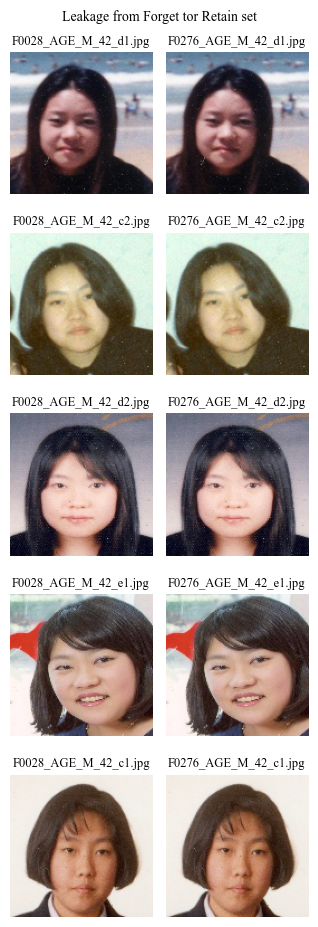

In [113]:
create_image_plot(forget_retain_leakage, splits=("forget", "retain"), title="Leakage from Forget tor Retain set", image_idx=[2, 6, 10, 15, 23])

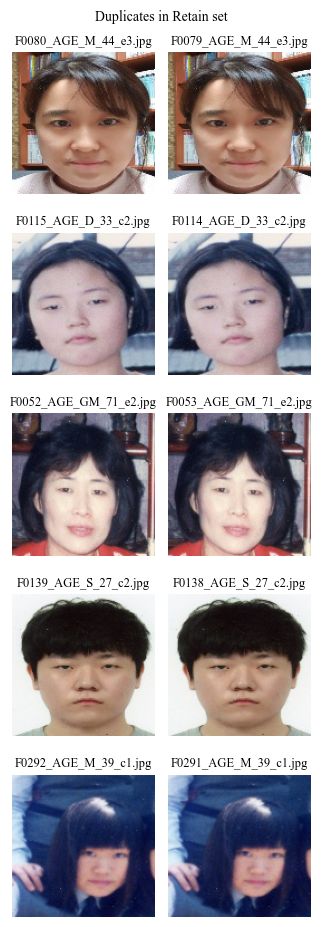

In [114]:
create_image_plot(
    retain_duplicates,
    splits=("retain", "retain"),
    title="Duplicates in Retain set",
    image_idx=[3, 5, 6, 17, 18],
)